In [18]:
import ROOT
import os
import numpy as np

%run ../src/plotting_toolkit.py
%run ../src/photoproduction_helper.py
%run ../src/electroproduction_helper.py

In [11]:
def N_EPA(Eb, Eg, Q2_max):
    alpha = 1 / 137.0
    PI = 3.14159265358979312

    x = Eg / Eb
    me = 0.000511
    Mp = 0.9383
    Q2_min = me * me * x * x / (1 - x)
    result = (1 / Eb) * alpha / (PI * x) * ((1 - x + x * x / 2) * np.log(Q2_max / Q2_min) - (1 - x))
    
    return result



In [30]:
beamE = 8.8
kmin  = 5.67
kmax  = 8.8
d     = 15
X0    = 769.1
q2_cut = 150

flux_brem, gammaE = Bremmstrahlung(kmin,kmax,beamE,d,X0)
flux_epa = N_EquivalentPhotonApproximation(gammaE,beamE,q2_cut)
flux_epa_2 = N_EPA(beamE, gammaE,q2_cut)
flux_epa = N_EquivalentPhotonApproximation(6.7,8.8,0.2)
print("gammaE =",gammaE)
print("Brem Flux =",flux_brem)
print("EPA Flux =",flux_epa)
print("EPA Flux v2 = ",flux_epa_2)

gammaE = 6.8532617164750596
Brem Flux = 0.0012827048680387227
EPA Flux = 0.0202318762107866
EPA Flux v2 =  0.003331875985857366


In [42]:
N=int(1e5)
flux = []
Q2 = []
h = ROOT.TH1F("h","",100,0,0.02)
eIn = ROOT.TLorentzVector(0,0,beamE,np.sqrt(beamE**2-mE**2))
eOut = ROOT.TLorentzVector()
hIn = ROOT.TLorentzVector(0,0,0,mD)
for i in range(N):
    f,q = VirtualPhoton(kmin,kmax,beamE,mD,eIn,eOut,hIn)
    flux.append(f)
    Q2.append(-q.M2())
    h.Fill(-q.M2(),f)

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


0.0017448034484684467


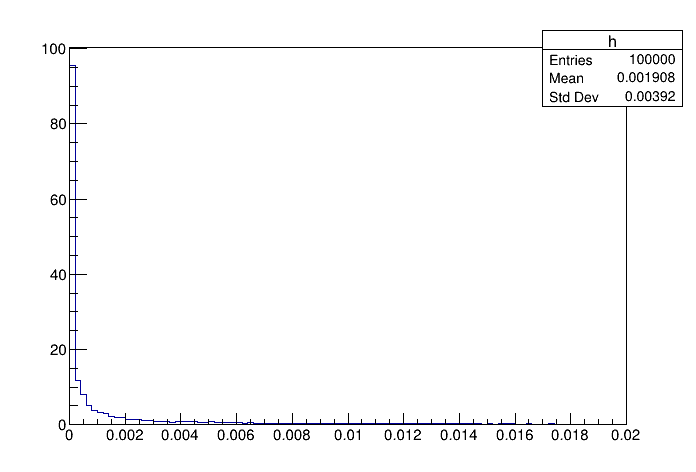

In [43]:
c=ROOT.TCanvas()
h.Draw("hist")
print(h.Integral()/N)
c.Draw()

In [63]:
PROJECT_NAME = "test6"
PROJECT_PATH = "/volatile/clas12/users/gmat/solid.data/projects/"
TARGET_TYPE  = "d"
PLOT_DIR = f"./plots/{PROJECT_NAME}/detected_events"
PLOT_DIR_PNG = f"{PLOT_DIR}/png"
PLOT_DIR_PDF = f"{PLOT_DIR}/pdf"
try:
    os.makedirs(PLOT_DIR)
    os.makedirs(PLOT_DIR_PNG)
    os.makedirs(PLOT_DIR_PDF)
    print(f"Created directory: {PLOT_DIR}")
except:
    pass

Created directory: ./plots/test6/detected_events


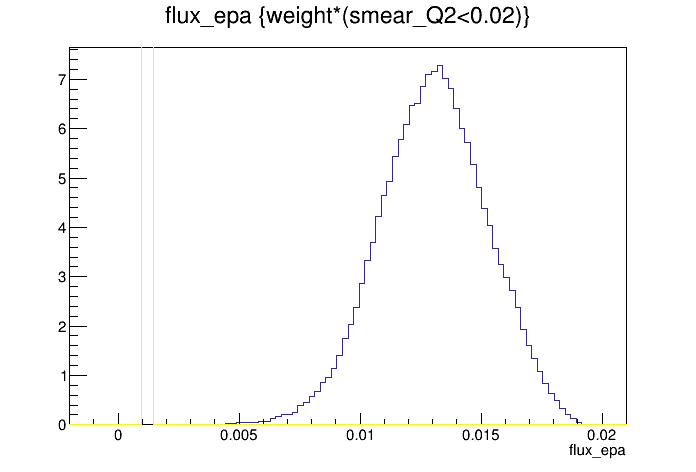

In [76]:
c=ROOT.TCanvas()

photo_tree.Draw("flux_epa","weight*(smear_Q2<0.02)","PLC hist")
photo_tree.Draw("flux_brem","weight*(smear_Q2<0.02)","PLC hist same")
c.Draw()

In [64]:
bh_tree, photo_tree, electro_tree = get_tchains(PROJECT_NAME,PROJECT_PATH,"acc")

beam_energy, integrated_luminosity, bh_events, days = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"bh")
_, _, photo_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"photoproduction")
_, _, electro_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"electroproduction")

luminosity = get_lumi_from_integrated(integrated_luminosity,TARGET_TYPE,days)

In [65]:
evtgen_dict = {
    "bh" : {
        "name" : "Bethe-Heitler",
        "tcut" : f"acc_ePlus*acc_eMinus*acc_hOut*weight*{integrated_luminosity/bh_events}",
        "ttree": bh_tree,
    },
    "photo" : {
        "name" : "J/#Psi Photoproduction",
        "tcut" : f"acc_ePlus*acc_eMinus*acc_hOut*weight*{integrated_luminosity/photo_events}",
        "ttree": photo_tree
    },
    "electro" : {
        "name" : "J/#Psi Electroproduction",
        "tcut" : f"acc_ePlus*acc_eMinus*acc_hOut*weight*{integrated_luminosity/electro_events}",
        "ttree": electro_tree
    }
}


plot_dict = {
    "Q2" : {
        "xtitle" : "Q^{2} [GeV^{2}]",
        "branch" : "abs(smear_q.M2())" ,
        "hist"   : ROOT.TH1F("hist","",100,0,0.3),
    },
    "t" : {
        "xtitle" : "-t [GeV^{2}]",
        "branch" : "-smear_t" ,
        "hist"   : ROOT.TH1F("hist","",100,0,3)
    },
    "gammaE" : {
        "xtitle" : "E_{#gamma} [GeV]",
        "branch" : "smear_q.E()" ,
        "hist"   : ROOT.TH1F("hist","",100,5.5,9)
    },
    "VM" : {
        "xtitle" : "M_{e^{+}e^{-}} [GeV]",
        "branch" : "smear_VM.M()" ,
        "hist"   : ROOT.TH1F("hist","",100,2.4,3.8)
    },
    "W" : {
        "xtitle" : "W [GeV]",
        "branch" : "smear_W",
        "hist"   : ROOT.TH1F("hist","",100,5,6.5)
    },
    "t_vs_gammaE" : {
        "xtitle" : "E_{#gamma} [GeV]",
        "xbranch" : "smear_q.E()",
        "ytitle" : "-t [GeV^{2}]",
        "ybranch" : "-smear_t",
        "hist" : ROOT.TH2F("hist","",100,6.5,9,100,0,3)
    },
    "sigmat_vs_t" : {
        "xtitle" : "-t [GeV^{2}]",
        "xbranch" : "-smear_t",
        "ytitle" : "#delta t [GeV^{2}]",
        "ybranch" : "-t+smear_t",
        "hist" : ROOT.TH2F("hist","",100,0,3,100,-0.5,0.5)
    },
    "sigmaE_vs_E" : {
        "xtitle" : "E [GeV]",
        "xbranch" : "smear_q.E()",
        "ytitle" : "#delta E [GeV]",
        "ybranch" : "gammaE-smear_q.E()",
        "hist" : ROOT.TH2F("hist","",100,6.5,9,100,-0.5,0.5)
    }
}

cut_dict = {
    "none" : {
        "tcut" : "",
        "cutstrings" : []
    },
    "Q2only" : {
        "tcut" : "(abs(smear_q.M2())<0.02)",
        "cutstrings" : ["|Q^{2}| < 0.02 GeV^{2}"]
    },
    "ana" : {
        "tcut" : "(abs(smear_q.M2())<0.02 && smear_VM.M()>3&&smear_VM.M()<3.2)",
        "cutstrings" : ["|Q^{2}| < 0.02 GeV^{2}", "3.0 < M_{ee} < 3.2 GeV"]
    }
}

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


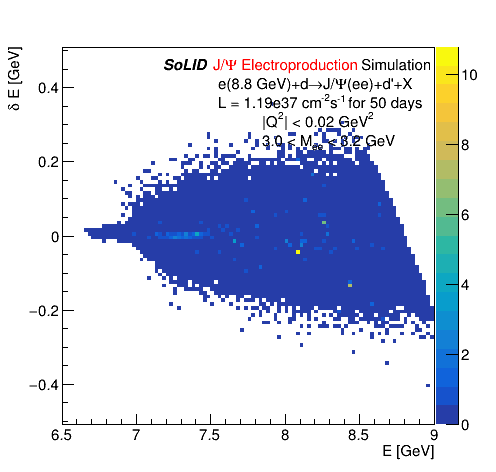

In [66]:
plot_number = 20000
ROOT.gErrorIgnoreLevel = ROOT.kError
for plot, plot_values in plot_dict.items():
    for evtgen, evtgen_values in evtgen_dict.items():
        for cut, cut_values in cut_dict.items():

            c = ROOT.TCanvas("c","c",500,500)
            ROOT.gStyle.SetOptStat(0)
            ROOT.gPad.SetRightMargin(0.125)
            ROOT.gPad.SetLeftMargin(0.125)
            tree = evtgen_values["ttree"]
            h    = plot_values["hist"].Clone()
            h.SetLineColor(1)
            h.SetLineWidth(2)
            h.SetName(f"hist_{plot_number}")
            weight_str = evtgen_values['tcut']
            if cut_values['tcut']:
                weight_str+="*"+cut_values['tcut']
            if ROOT.TH1F == type(h):
                draw_str = f"{plot_values['branch']}>>hist_{plot_number}"
                h_title = f";{plot_values['xtitle']};Counts"
                option_str = "hist"
            else:
                draw_str = f"{plot_values['ybranch']}:{plot_values['xbranch']}>>hist_{plot_number}"
                h_title = f";{plot_values['xtitle']};{plot_values['ytitle']}"
                option_str = "colz"
                if "sigma" not in plot:
                    ROOT.gPad.SetLogz()

            tree.Draw(draw_str, weight_str, "goff")
            h.SetTitle(h_title)
            h.Draw(option_str)
            if type(h)==ROOT.TH1F:
                h.GetYaxis().SetRangeUser(0,h.GetMaximum()*1.2)
            else:
                h.GetYaxis().SetRangeUser(-h.GetMaximum()*1.2,h.GetMaximum()*1.2)
            dy = 0.04
            x1 = 0.33 if evtgen!="bh" else 0.4
            x2 = 0.44
            y  = 0.85 
            latex = ROOT.TLatex()
            latex.SetTextSize(dy-0.005)
            latex.SetTextFont(42)
            latex.DrawLatexNDC(x1,y,"#bf{#it{SoLID}} #color[2]{"+evtgen_values["name"]+"} Simulation")
            latex.DrawLatexNDC(x2,y-dy,f"e({beam_energy} GeV)+d#rightarrow"+("J/#Psi(ee)" if evtgen!="bh" else "(e^{+}+e^{-})") + "+d'+X")
            latex.DrawLatexNDC(x2,y-2*dy,f"L = {luminosity} cm^{{-2}}s^{{-1}} for {days:0.0f} days")
            for i in range(len(cut_values['cutstrings'])):
                latex.DrawLatexNDC(x2+0.09,y-(3+i)*dy,cut_values['cutstrings'][i])
            plot_name = f"{evtgen}_{plot}"
            c.SaveAs(f"{PLOT_DIR_PNG}/{plot_name}.cut_{cut}.png")
            c.SaveAs(f"{PLOT_DIR_PDF}/{plot_name}.cut_{cut}.pdf")
            c.Draw()
            plot_number+=1


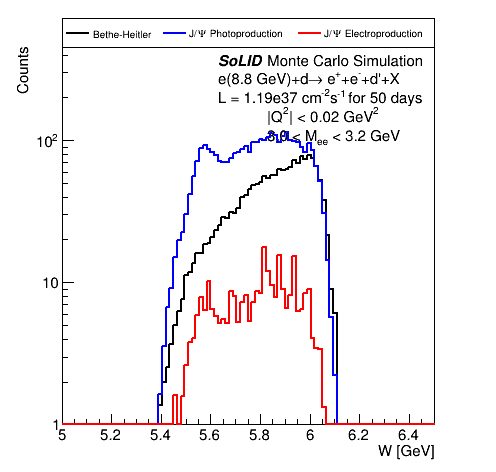

In [67]:
plot_number = 0 
ROOT.gErrorIgnoreLevel = ROOT.kError
for cut, cut_values in cut_dict.items():
    for plot, plot_values in plot_dict.items():
        h    = plot_values["hist"].Clone()
        if type(h) == ROOT.TH2F:
            continue
        c = ROOT.TCanvas("c","c",500,500)
        H=[]
        legend=ROOT.TLegend(0.125,0.9,0.875,0.96)
        legend.SetNColumns(3)

        for evtgen, evtgen_values in evtgen_dict.items():

            ROOT.gPad.SetLogy()
            ROOT.gStyle.SetOptStat(0)
            ROOT.gPad.SetRightMargin(0.125)
            ROOT.gPad.SetLeftMargin(0.125)
            tree = evtgen_values["ttree"]
            h    = plot_values["hist"].Clone()

            h.SetLineColor(1)
            h.SetLineWidth(2)
            h.SetName(f"hist_{plot_number}")
            weight_str = evtgen_values['tcut']
            if cut_values['tcut']:
                weight_str+="*"+cut_values['tcut']
            draw_str = f"{plot_values['branch']}>>hist_{plot_number}"
            h_title = f";{plot_values['xtitle']};Counts"
            option_str = "hist"

            tree.Draw(draw_str, weight_str, "goff")
            h.SetTitle(h_title)
            if evtgen=="bh":
                h.SetLineColor(1)
            elif evtgen=="photo":
                h.SetLineColor(4)
            else:
                h.SetLineColor(2)


            H.append(h)
            H[-1].Draw(option_str + " same")
            legend.AddEntry(H[-1],evtgen_values["name"],"l")
            plot_number+=1

        if type(H[-1]) == ROOT.TH1F:
            ymax = H[-1].GetMaximum()
            for h in H:
                ymax0 = h.GetMaximum()
                if ymax0>ymax:
                    ymax=ymax0

        H[0].GetYaxis().SetRangeUser(1,ymax*4)
        dy = 0.04
        x1 = 0.44
        x2 = 0.44
        y  = 0.86 
        latex = ROOT.TLatex()
        latex.SetTextSize(dy-0.005)
        latex.SetTextFont(42)
        latex.DrawLatexNDC(x1,y,"#bf{#it{SoLID}} Monte Carlo Simulation")
        latex.DrawLatexNDC(x2,y-dy,f"e({beam_energy} GeV)+d#rightarrow e^{{+}}+e^{{-}}+{TARGET_TYPE}'+X")
        latex.DrawLatexNDC(x2,y-2*dy,f"L = {luminosity} cm^{{-2}}s^{{-1}} for {days:0.0f} days")
        for i in range(len(cut_values['cutstrings'])):
            latex.DrawLatexNDC(x2+0.1,y-(3+i)*dy,cut_values['cutstrings'][i])
        legend.Draw("same")
        plot_name = f"{plot}"
        c.SaveAs(f"{PLOT_DIR_PNG}/all.{plot_name}.cut_{cut}.png")
        c.SaveAs(f"{PLOT_DIR_PDF}/all.{plot_name}.cut_{cut}.pdf")
        c.Draw()
    
            

In [5]:
bh_tree, photo_tree, electro_tree = get_tchains(PROJECT_NAME,PROJECT_PATH,"all")

beam_energy, integrated_luminosity, bh_events, days = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"bh")
_, _, photo_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"photoproduction")
_, _, electro_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"electroproduction")

luminosity = get_lumi_from_integrated(integrated_luminosity,TARGET_TYPE,days)

In [6]:
%run ../src/dvmp_cross_section.py
DVMP = dvmpProduction("d","PomeronLQCD")

/opt/root/lib/ROOT/_facade.py:121: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  return _orig_ihook(name, *args, **kwds)


8.602409638554217


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hcounts (Potential memory leak).


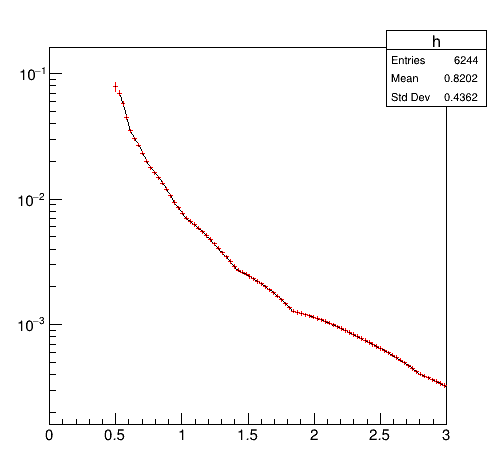

In [20]:
def get_TGraph_dsigma_dt(E):
    idx_E = np.abs(E - DVMP.E_deuteron).argmin() # Find closest value to desired energy in the dsigmadt table
    E = DVMP.E_deuteron[idx_E]
    print(E)
    dsdt = DVMP.DSDT_deuteron[DVMP.E_deuteron==E]
    kinematic_tmin = DVMP.get_tmin(E)
    t = DVMP.T_deuteron[DVMP.E_deuteron==E] #+ kinematic_tmin
    
    graph = ROOT.TGraph(len(t))
    for i in range(len(t)):
        graph.SetPoint(i,t[i],dsdt[i])
    graph.SetMarkerStyle(20)
    graph.SetMarkerSize(0.1)
    return graph

c=ROOT.TCanvas("c","c",500,500)
Emin = 8.4
Emax = 8.8
graph = get_TGraph_dsigma_dt(0.5*(Emax+Emin))
h = ROOT.TH1F("h","",100,0,3)
hcounts = ROOT.TH1F("hcounts","",100,0,3)
deltat = h.GetBinWidth(2)
h.SetLineColor(2)
evts = photo_events

photo_tree.Draw("-t>>h",f"dsigma*({Emax}>gammaE&&{Emin}<gammaE)")
photo_tree.Draw("-t>>hcounts",f"({Emax}>gammaE&&{Emin}<gammaE)","goff")
h.Divide(hcounts)
graph.Draw("l same")
h.Draw("P same")
c.SetLogy()
c.Draw()

8.602409638554217


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TList::Clear>: A list is accessing an object (0x55ccb94234d0) already deleted (list name = TList)


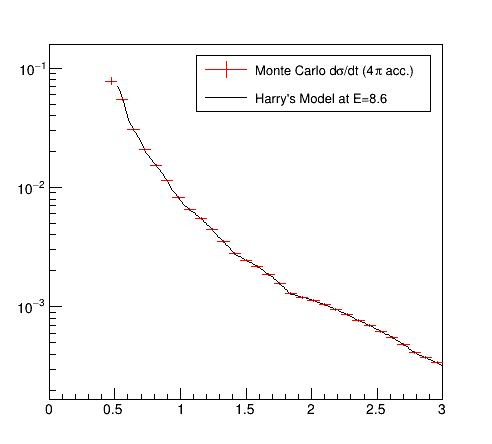

In [31]:
import copy
def plot_dsigma_dt_histogram_and_graph(photo_tree, Emin, Emax):
    """
    Plot histogram and graph for dsigma/dt for given energy range

    Parameters:
    - photo_tree: Input TTree with data
    - Emin, Emax: Energy range for which to consider events
    """

    # Create canvas
    c = ROOT.TCanvas("c", "c", 500, 500)

    # Prepare the histogram
    h = ROOT.TH1F("h", "", 35, 0, 3)
    h.SetLineColor(2)
    hcounts = ROOT.TH1F("hcounts", "", 35, 0, 3)
    
    # Define the energy range and conditions
    energy_condition = f"{Emax}>gammaE && {Emin}<gammaE"

    # Fill histograms with data from the tree
    photo_tree.Draw("-t>>h", f"dsigma*({energy_condition})")
    photo_tree.Draw("-t>>hcounts", energy_condition, "goff")
    
    # Normalize the main histogram
    h.Divide(hcounts)

    # Get the graph for dsigma/dt
    mid_energy = 0.5 * (Emax + Emin)
    graph = get_TGraph_dsigma_dt(mid_energy)

    # Draw graph and histogram
    graph.Draw("l same")
    h.Draw("P same")
    
    # Draw TLegend
    legend = ROOT.TLegend(0.4,0.75,0.875,0.875)
    legend.AddEntry(h,"Monte Carlo d#sigma/dt (4#pi acc.)","le")
    legend.AddEntry(graph,f"Harry's Model at E={mid_energy:.1f}","l")
    legend.Draw()
    # Set log scale on y-axis
    c.SetLogy()
    ROOT.gStyle.SetOptStat(0)

    return copy.deepcopy(c)

# Given energy range
Emin = 8.4
Emax = 8.8

# Assuming photo_events is defined somewhere above in the original script
evts = photo_events

# Execute the function
c=plot_dsigma_dt_histogram_and_graph(photo_tree, Emin, Emax)
c.Draw()

In [38]:
GenPhase = ROOT.TGenPhaseSpace()
VM = ROOT.TLorentzVector(0,0,0,3)
m  = 0.000511
GenPhase.SetDecay(VM,2,np.array([m,m]))
N = int(1e6)

theta = []
phi = []
w   = []

for i in range(N):
    GenPhase.Generate()
    p1 = GenPhase.GetDecay(0)
    theta.append(p1.Theta())
    phi.append(p1.Phi())
    r=0
    w.append(3/8/np.pi*(1-r+(3*r-1)*np.cos(p1.Theta())**2))

Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).


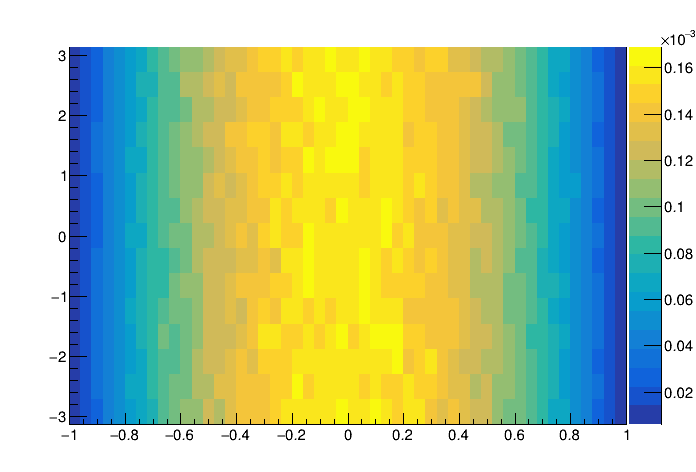

In [49]:
h2 = ROOT.TH2F("h2","",50,-1,1,15,-np.pi,np.pi)
for i in range(N):
    h2.Fill(np.cos(theta[i]),phi[i],w[i]/N)
c=ROOT.TCanvas()
h2.Draw("colz")
c.Draw()

In [50]:
h2.Integral()*4*np.pi

0.9991659406148417

In [45]:
4*np.pi

12.566370614359172